### Implementing a single-compartment HH Model

**Khulud Nurani & Stephen Kiilu**

**Imbizo South Africa 2024**

The Hodgkin-Huxley model, formulated over 70 years ago to describe how action potentials in neurons are initiated and propagated, ranks amongst the most significant conceptual breakthroughs in neuroscience. Over time, it has been implemented to better understand various physiological processes and pathological states affecting the nervous system. When it comes to seizures in particular, the model has provided a framework of understanding with the advantage of being detailed from a biophysical point of view. In this study, we will manipulate the H-H model to simulate seizures due to various underlying causes and the effect of sodium channel blockers.

By implementing the H-H model we hope to gain a better understanding of neuronal modeling and to illustrate seizure dynamics.


In [ ]:
# Installation & import of Brian (2)
!pip install brian2
from brian2 import*
prefs.codegen.target = "numpy"

The H-H Model:

Im = gl * (El-v) + gNa * m**3 * h * (ENa-v) + gK * n*4 * (EK-v) : amp/meter*2

I : amp (point current) # applied current

dm/dt = alpham * (1-m) - betam * m : 1

dn/dt = alphan * (1-n) - betan * n : 1

dh/dt = alphah * (1-h) - betah * h : 1


# Modeling a simple neuron

In [ ]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

G = NeuronGroup(1, eqs)
run(100*ms)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]


In [ ]:
start_scope()

G = NeuronGroup(1, eqs, method='exact')
print('Before v = %s' % G.v[0])
run(100*ms)
print('After v = %s' % G.v[0])

Before v = 0.0
After v = 0.9999546000702376


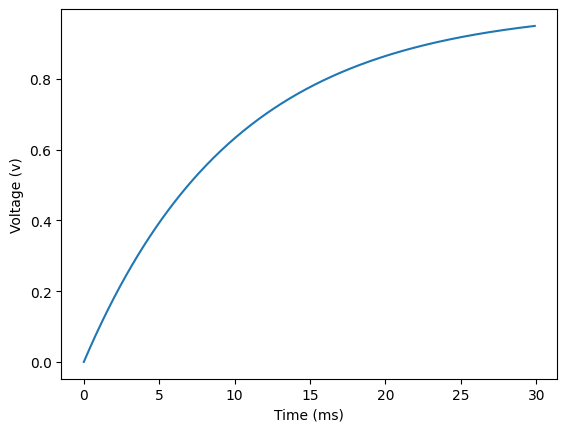

In [ ]:
start_scope()

G = NeuronGroup(1, eqs, method='exact')
M = StateMonitor(G, 'v', record=True)

run(30*ms)

plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('Voltage (v)');

# Adding Spikes

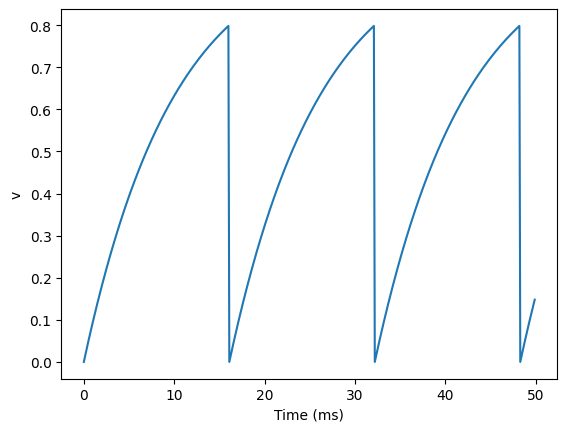

In [ ]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')

M = StateMonitor(G, 'v', record=0)
run(50*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

# Adding Refractoriness

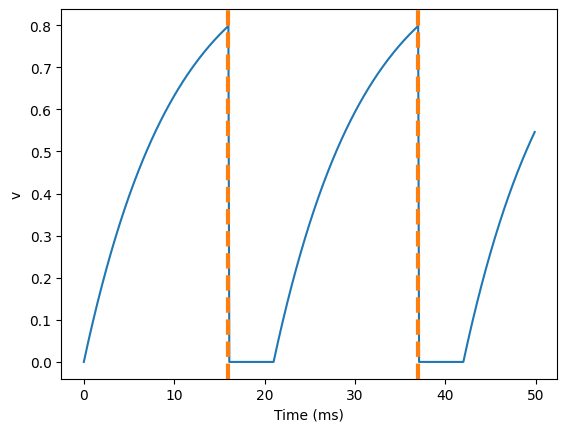

In [ ]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1 (unless refractory)
'''

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', refractory=5*ms, method='exact')

statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
xlabel('Time (ms)')
ylabel('v');

# HH Model

Random Current

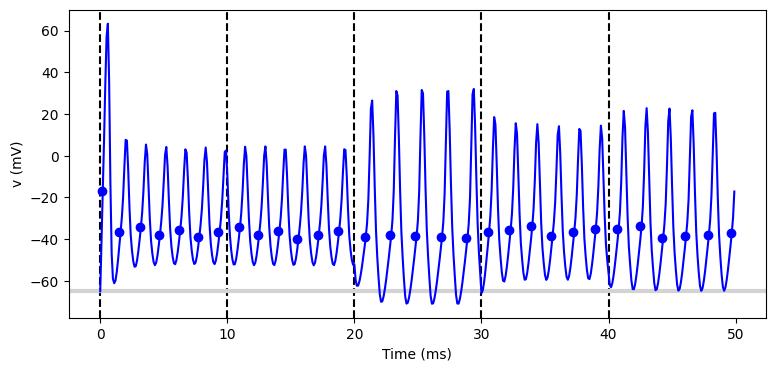

In [ ]:
start_scope()
#Creating model variables
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV

#The HH Equation
eqs_HH = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
'''

group = NeuronGroup(1, eqs_HH,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
statemon = StateMonitor(group, 'v', record=True) #Monitoring variables activity
spikemon = SpikeMonitor(group, variables='v') #Recording spiking activity
figure(figsize=(9, 4)) #Plotting the voltage as it changes over time
for l in range(5):
    group.I = rand()*50*nA
    run(10*ms)
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)
plot(statemon.t/ms, statemon.v[0]/mV, '-b')
plot(spikemon.t/ms, spikemon.v/mV, 'ob')
xlabel('Time (ms)')
ylabel('v (mV)');

**Current vs Firing Rate** (Input vs Output)

In [ ]:
start_scope()
num_neurons = 100
duration = 2*second

# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV

# The model
eqs = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*4*mV/exprel((13.*mV-v+VT)/(4*mV))/ms*(1-m)-0.28*(mV**-1)*5*mV/exprel((v-VT-40.*mV)/(5*mV))/ms*m : 1
dn/dt = 0.032*(mV**-1)*5*mV/exprel((15.*mV-v+VT)/(5*mV))/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
''')
# Threshold and refractoriness are only used for spike counting
group = NeuronGroup(num_neurons, eqs,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
group.I = '0.7*nA * i / num_neurons'

monitor = SpikeMonitor(group)

run(duration)

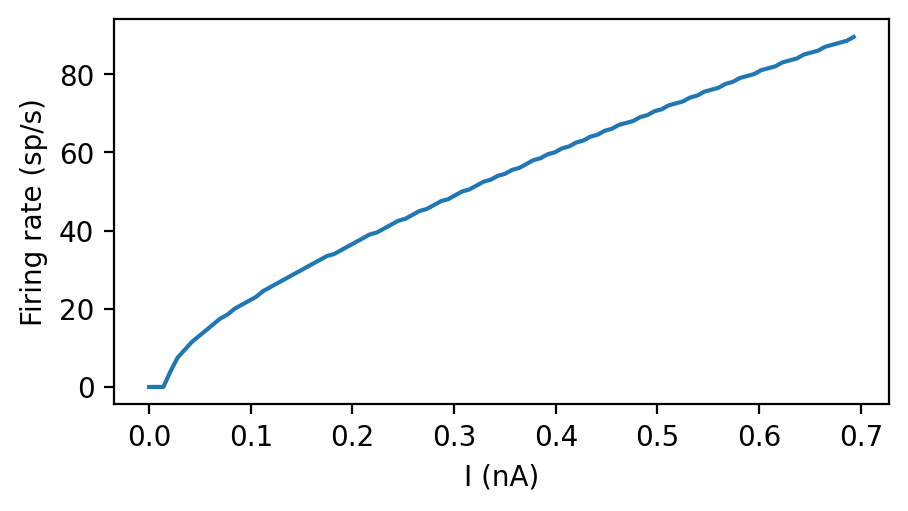

In [ ]:
figure(figsize=(5, 2.5), dpi=200)
plot(group.I/nA, monitor.count / duration)
xlabel('I (nA)')
ylabel('Firing rate (sp/s)')
show()

**PLOT 1** Input Current= Set value

In [ ]:
#Initiate Brian2
start_scope()
#Creating model variables
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV
dur = 200*ms

#The HH Equation
eqs_HH = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
'''
#creates a single-neuron group
group = NeuronGroup(1, eqs_HH,
                    threshold='v > -40*mV', #spikes when the membrane potential exceeds -40 mV
                    refractory='v > -40*mV', #refractory period during and after the spike
                    method='exponential_euler')
#Setting the initial membrane potential of the neuron to the leak reversal potential
group.v = El
statemon = StateMonitor(group, ['v', 'm', 'n', 'h'], record=True) #Monitoring variables activity
spikemon = SpikeMonitor(group, variables='v') #Recording spiking activity

group.I = 100*pA
run(dur)


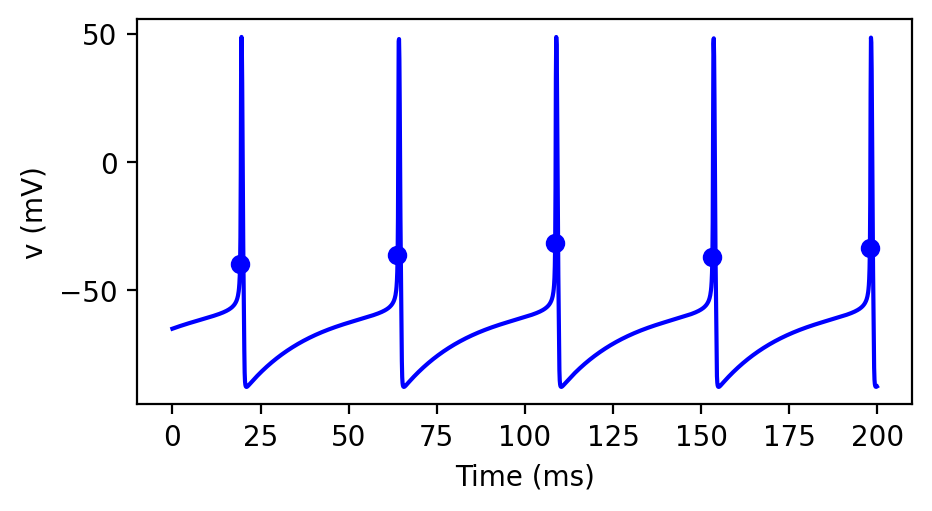

In [ ]:
figure(figsize=(5, 2.5), dpi=200) #Plotting the voltage as it changes over time
plot(statemon.t/ms, statemon.v[0]/mV, '-b')
plot(spikemon.t/ms, spikemon.v/mV, 'ob')
# title ('Graph of Voltage against Time')
xlabel('Time (ms)')
ylabel('v (mV)');

# Graphs of h,n, and m against time

Plot of sodium channel subunit activation (m)

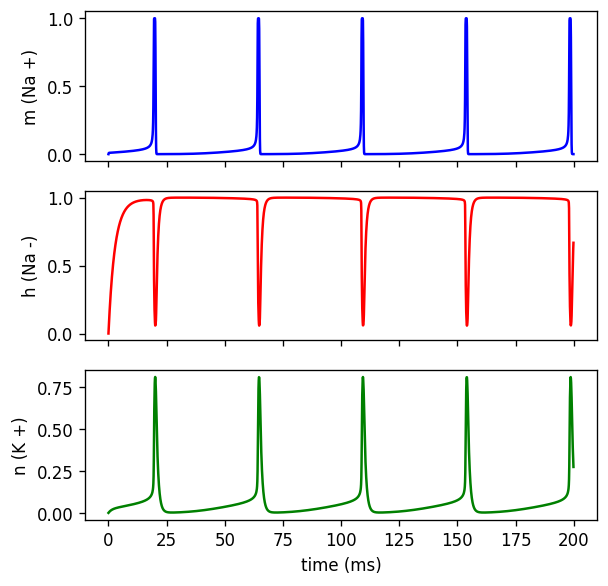

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(5.5,5.5), dpi=120, sharex=True)
ax[0].plot(statemon.t/ms, statemon.m[0], '-b')
ax[1].plot(statemon.t/ms, statemon.h[0], '-r')
ax[2].plot(statemon.t/ms, statemon.n[0], '-g')
ax[0].set(ylabel='m (Na +)')
ax[1].set(ylabel='h (Na -)')
ax[2].set(ylabel='n (K +)')
ax[2].set(xlabel='time (ms)');

In [ ]:
#creates a single-neuron group
# group = NeuronGroup(1, eqs_HH,
#                     threshold='v > -40*mV', #spikes when the membrane potential exceeds -40 mV
#                     refractory='v > -40*mV', #refractory period during and after the spike
#                     method='exponential_euler')
# #Setting the initial membrane potential of the neuron to the leak reversal potential
# group.v = El
# statemon = StateMonitor(group, ['v','m','n','h'], record=True) #Monitoring variables activity
# spikemon = SpikeMonitor(group, variables='v') #Recording spiking activity

# figure(figsize=(9, 4)) #Plotting the voltage as it changes over time
# group.I = 100*pA
# run(dur)
# plot(statemon.t/ms, statemon.m[0], '-b')
# title ('Plot of sodium channel subunit activation (m)')
# xlabel('Time (ms)')
# ylabel('v (mV)');


Plot of sodium channel subunit inactivation (h)

In [ ]:
#creates a single-neuron group
# group = NeuronGroup(1, eqs_HH,
#                     threshold='v > -40*mV', #spikes when the membrane potential exceeds -40 mV
#                     refractory='v > -40*mV', #refractory period during and after the spike
#                     method='exponential_euler')
# #Setting the initial membrane potential of the neuron to the leak reversal potential
# group.v = El
# statemon = StateMonitor(group, ['v','m','n','h'], record=True) #Monitoring variables activity
# spikemon = SpikeMonitor(group, variables='v') #Recording spiking activity

# figure(figsize=(9, 4)) #Plotting the voltage as it changes over time
# group.I = 100*pA
# run(dur)
# plot(statemon.t/ms, statemon.h[0], '-b')
# title ('Plot of sodium channel subunit inactivation (h)')
# xlabel('Time (ms)')
# ylabel('v (mV)');

Plot of potassium channel subunit activation (n)

In [ ]:
#creates a single-neuron group
# group = NeuronGroup(1, eqs_HH,
#                     threshold='v > -40*mV', #spikes when the membrane potential exceeds -40 mV
#                     refractory='v > -40*mV', #refractory period during and after the spike
#                     method='exponential_euler')
# #Setting the initial membrane potential of the neuron to the leak reversal potential
# group.v = El
# statemon = StateMonitor(group, ['v','m','n','h'], record=True) #Monitoring variables activity
# spikemon = SpikeMonitor(group, variables='v') #Recording spiking activity

# figure(figsize=(9, 4)) #Plotting the voltage as it changes over time
# group.I = 100*pA
# run(dur)
# plot(statemon.t/ms, statemon.n[0], '-b')
# title ('Plot of potassium channel subunit activation (n)')
# xlabel('Time (ms)')
# ylabel('v (mV)');

**Combined Plot**

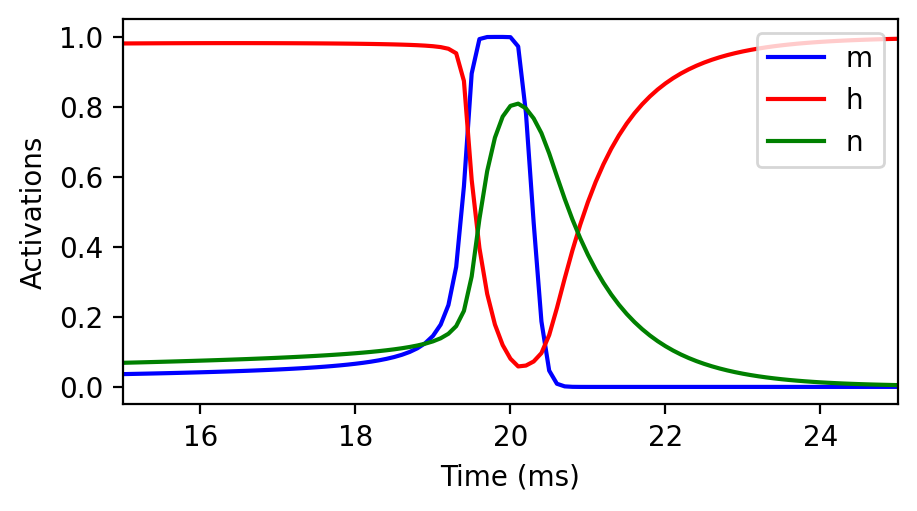

In [ ]:
#creates a single-neuron group
group = NeuronGroup(1, eqs_HH,
                    threshold='v > -40*mV', #spikes when the membrane potential exceeds -40 mV
                    refractory='v > -40*mV', #refractory period during and after the spike
                    method='exponential_euler')
#Setting the initial membrane potential of the neuron to the leak reversal potential
group.v = El
statemon = StateMonitor(group, ['v','m','n','h'], record=True) #Monitoring variables activity
spikemon = SpikeMonitor(group, variables='v') #Recording spiking activity

figure(figsize=(5, 2.5),dpi=200) #Plotting the voltage as it changes over time
group.I = 100*pA
run(dur)
plot(statemon.t/ms, statemon.m[0], '-b', label='m')
plot(statemon.t/ms, statemon.h[0], '-r', label='h')
plot(statemon.t/ms, statemon.n[0], '-g', label='n')
plt.xlim([15, 25])
legend (loc=1)
xlabel('Time (ms)')
ylabel('Activations');

# Comparison of Diff Input Current

The rate is 5
The rate is 10
The rate is 16


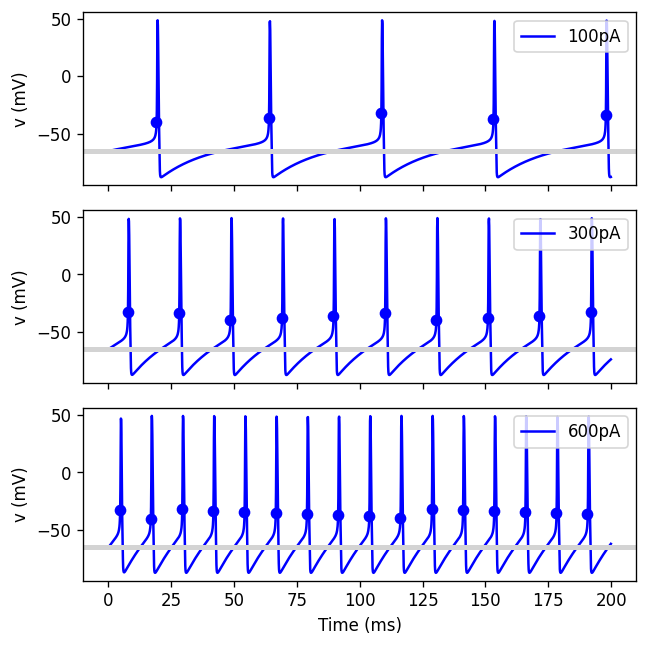

In [ ]:
import matplotlib.pyplot as plt
#Initiate Brian2
start_scope()
#Creating model variables
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV

# simulation duration
dur = 200*ms

#The HH Equation
eqs_HH = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
'''
#creates a single-neuron group
group = NeuronGroup(1, eqs_HH,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El

# Create Monitors
statemon = StateMonitor(group, 'v', record=True)
spikemon = SpikeMonitor(group, variables='v')

# Set up figure with two subplots
fig, axs = plt.subplots(3, 1, figsize=(5.5,5.5), dpi=120, sharex=True)

# Simulation for the first input current
group.I = 100 * pA
run(dur)

# Plot the first graph on the first subplot
axs[0].plot(statemon.t/ms, statemon.v[0]/mV, '-b',label='100pA')
axs[0].plot(spikemon.t/ms, spikemon.v/mV, 'ob')
axs[0].axhline(El/mV, ls='-', c='lightgray', lw=3)
axs[0].set_ylabel('v (mV)')
# axs[0].set_xlabel('Time (ms)')
axs[0].legend(loc=1)
rate1=len(spikemon.t/dur)
print(f'The rate is {rate1}')

# Simulation for the second input current
start_scope()

#creates a single-neuron group
group = NeuronGroup(1, eqs_HH,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')

# reset membrane potential to rest
group.v = El

# Create Monitors
statemon2 = StateMonitor(group, 'v', record=True)
spikemon2 = SpikeMonitor(group, variables='v')

# higher input
group.I = 300 * pA  # Change the input current
run(dur)

# Plot the second graph on the second subplot
axs[1].plot(statemon2.t/ms, statemon2.v[0]/mV, '-b',label='300pA')
axs[1].plot(spikemon2.t/ms, spikemon2.v/mV, 'ob')
axs[1].axhline(El/mV, ls='-', c='lightgray', lw=3)
# axs[1].set_xlabel('Time (ms)')
axs[1].set_ylabel('v (mV)')
axs[1].legend(loc=1)
rate2=len(spikemon2.t/dur)
print(f'The rate is {rate2}')

# Simulation for the third input current
start_scope()

#creates a single-neuron group
group = NeuronGroup(1, eqs_HH,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')

# reset membrane potential to rest
group.v = El

# Create Monitors
statemon3 = StateMonitor(group, 'v', record=True)
spikemon3 = SpikeMonitor(group, variables='v')

# higher input
group.I = 600 * pA  # Change the input current
run(dur)

# Plot the third graph on the third subplot
axs[2].plot(statemon3.t/ms, statemon3.v[0]/mV, '-b',label='600pA')
axs[2].plot(spikemon3.t/ms, spikemon3.v/mV, 'ob')
axs[2].axhline(El/mV, ls='-', c='lightgray', lw=3)
axs[2].set_xlabel('Time (ms)')
axs[2].set_ylabel('v (mV)')
axs[2].legend(loc=1)
rate3=len(spikemon3.t/dur)
print(f'The rate is {rate3}')

fig.tight_layout()
# Show the plot
plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# #Initiate Brian2
# start_scope()
# #Creating model variables
# area = 20000*umetre**2
# Cm = 1*ufarad*cm**-2 * area
# gl = 5e-5*siemens*cm**-2 * area
# El = -65*mV
# EK = -90*mV
# ENa = 50*mV
# g_na = 100*msiemens*cm**-2 * area
# g_kd = 30*msiemens*cm**-2 * area
# VT = -63*mV

# # simulation duration
# dur = 200*ms

# #The HH Equation
# eqs_HH = '''
# dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
# dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
#     (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
#     (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
# dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
#     (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
# dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
# I : amp
# '''
# #creates a single-neuron group
# group = NeuronGroup(1, eqs_HH,
#                     threshold='v > -40*mV',
#                     refractory='v > -40*mV',
#                     method='exponential_euler')
# group.v = El

# # Create Monitors
# statemon = StateMonitor(group, 'v', record=True)
# spikemon = SpikeMonitor(group, variables='v')

# # Simulation for the first input current
# group.I = 100 * pA
# run(dur)


In [ ]:
# fig, ax = plt.subplots(3, 1, figsize=(5.5,5.5), dpi=120, sharex=True)
# axs[0].plot(statemon.t/ms, statemon.v[0]/mV, '-b',label='100pA')
# axs[1].plot(statemon2.t/ms, statemon2.v[0]/mV, '-r',label='300pA')
# axs[2].plot(statemon3.t/ms, statemon3.v[0]/mV, '-g',label='600pA')
# ax[0].set(ylabel='v (mV)')
# ax[1].set(ylabel='v (mV)')
# ax[2].set(ylabel='v (mV)')
# ax[2].set(xlabel='Time (ms)');

Rates

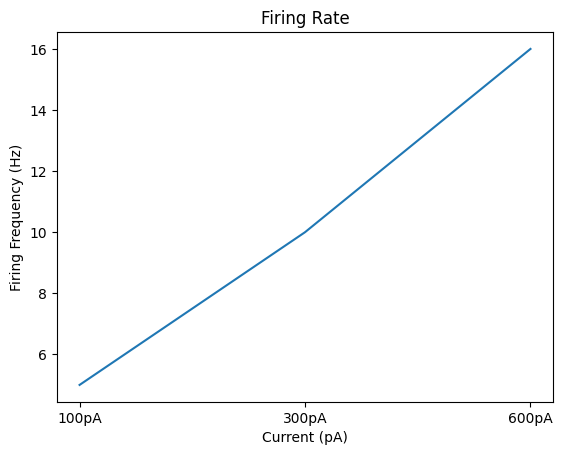

In [ ]:
# rate=[5,10,16]
# current=['100pA','300pA','600pA']
# ylabel('Firing Frequency (Hz)')
# xlabel('Current (pA)')
# title('Firing Rate')
# plt.plot(current, rate)